# **Домашняя работа: прогнозирование заработной платы и кластеризация типов движений**

### **Постановка задачи:**

В этой работе две части:

*   В первой части вам предстоит построить алгоритм на основе бустинга для прогнозирования зарплаты
*   Во второй части вам предстоит кластеризовать типы движений по имеющимся данным с акселерометров и гироскопов

### **Оценивание:**

- Как всегда оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.
- Брать код из открытых источников позволительно. Следование культуре цитирования **обязательно.**

### **Баллы:**

Суммарно за задание можно получить 10 основных и 1 бонусный балл.

Оценка за ДЗ = min{ваш балл, 10}

**Мягкий дедлайн: 16 февраля 23:59**

**Интересной вам работы!**


# **Часть 1. Прогнозирование заработной платы при помощи бустинга**

**Количество баллов:** 7

## **Постановка задачи:**

Данные выгружены и лежат в файле `ds_salary.csv`. Вам доступны описания признаков и значения целевой переменной.

**Ваша задача:** построение модели бустинга и оценка данной модели.

## **Описание даных**

- work_year: год, в который взяты данные;
- experience_level: уровень опыта, кодируемый как SE, MI EN или EX
- employment_type: тип занятости (FT, PT, CT, FL)
- job_title: название рабочей позиции в компании;
- salary: зараплата на позиции;
- salary_currency: валюта в которой начисляют зарплату;
- employee_residence: страна или регион проживания сотрудника
- remote_ratio: процент удаленки, предлагаемый в компании (0, 50, 100)
- company_location: местоположение компании
- company_size: размер компании, оцененный как S, M, L
- salary_in_usd: целевая переменная


Как всегда, загрузим набор данных.

In [ ]:
!pip install catboost
!pip install category_encoders

ERROR: Could not find a version that satisfies the requirement seaborn-darkgrid (from versions: none)
ERROR: No matching distribution found for seaborn-darkgrid


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, silhouette_score, davies_bouldin_score

from time import time
import joblib

In [ ]:
df = pd.read_csv("https://github.com/hse-ds/iad-intro-ds/raw/refs/heads/master/2023/homeworks/hw-08-boosting/ds_salaries.csv")

## **Задание 1 (0.3 балла)**

Вам даны описания переменных. Проверьте, что категориальные признаки, категории которых перечислены, не имеют ошибочных значений. Для этого:

- Напишите цикл, пробегающий по выбранным признакам и оценивающий, что в них нет лишних значений;

In [ ]:
df.head(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [ ]:
# Ваш код здесь
cat = {'experience_level': ['SE', 'MI', 'EN', 'EX'], 'employment_type': ['FT', 'PT', 'CT', 'FL'],
                 'remote_ratio': [0, 50, 100], 'company_size': ['S', 'M', 'L']}

In [ ]:
for column, all_values in cat.items():
    un_values = set(df[column].dropna().unique())

    if not un_values.issubset(all_values):
        values = un_values - set(all_values)
        print(f'В {column} есть значения: {values}')

## **Задание 2 (0.3 балла)**

Проведите базовые шаги оценки качества данных.
- Есть есть проблемы, устраните их;
- Если нет проблем, кратко опишите это.

In [ ]:
# Ваш код здесь
df.head(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2023,SE,FT,Principal Data Scientist,80000,EUR,85847,ES,100,ES,L
1,2023,MI,CT,ML Engineer,30000,USD,30000,US,100,US,S
2,2023,MI,CT,ML Engineer,25500,USD,25500,US,100,US,S
3,2023,SE,FT,Data Scientist,175000,USD,175000,CA,100,CA,M
4,2023,SE,FT,Data Scientist,120000,USD,120000,CA,100,CA,M


In [ ]:
df.tail(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3750,2020,SE,FT,Data Scientist,412000,USD,412000,US,100,US,L
3751,2021,MI,FT,Principal Data Scientist,151000,USD,151000,US,100,US,L
3752,2020,EN,FT,Data Scientist,105000,USD,105000,US,100,US,S
3753,2020,EN,CT,Business Data Analyst,100000,USD,100000,US,100,US,L
3754,2021,SE,FT,Data Science Manager,7000000,INR,94665,IN,50,IN,L


In [ ]:
df.sample(5)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
2809,2022,SE,FT,Data Engineer,105000,USD,105000,US,100,US,M
826,2023,SE,FT,Data Analyst,161500,USD,161500,US,100,US,M
2679,2022,SE,FT,Lead Data Scientist,156868,USD,156868,US,100,US,L
1943,2022,MI,FT,Data Engineer,120000,USD,120000,US,100,US,M
1337,2023,MI,FT,Data Engineer,62000,EUR,66531,ES,100,ES,M


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


In [ ]:
df.isnull().sum()

,0
work_year,0
experience_level,0
employment_type,0
job_title,0
salary,0
salary_currency,0
salary_in_usd,0
employee_residence,0
remote_ratio,0
company_location,0


In [ ]:
df.describe()

,work_year,salary,salary_in_usd,remote_ratio
count,3755.000000,3.755000e+03,3755.000000,3755.000000
mean,2022.373635,1.906956e+05,137570.389880,46.271638
std,0.691448,6.716765e+05,63055.625278,48.589050
min,2020.000000,6.000000e+03,5132.000000,0.000000
25%,2022.000000,1.000000e+05,95000.000000,0.000000
50%,2022.000000,1.380000e+05,135000.000000,0.000000
75%,2023.000000,1.800000e+05,175000.000000,100.000000
max,2023.000000,3.040000e+07,450000.000000,100.000000


In [ ]:
df.describe(include='object')

,experience_level,employment_type,job_title,salary_currency,employee_residence,company_location,company_size
count,3755,3755,3755,3755,3755,3755,3755
unique,4,4,93,20,78,72,3
top,SE,FT,Data Engineer,USD,US,US,M
freq,2516,3718,1040,3224,3004,3040,3153


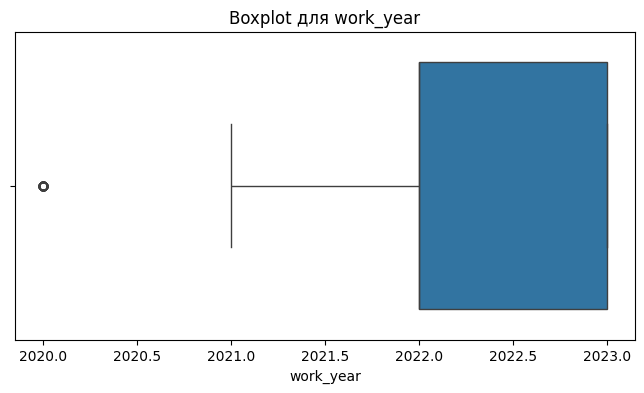

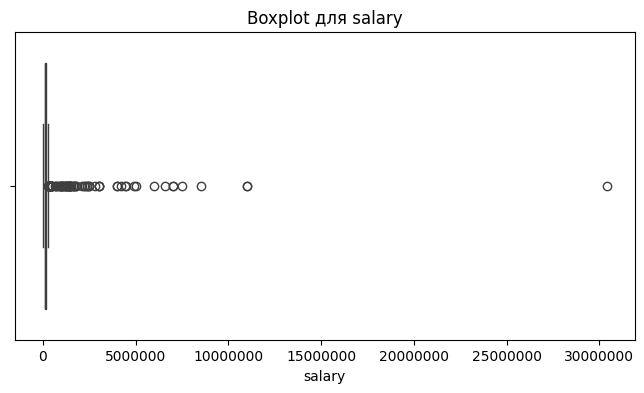

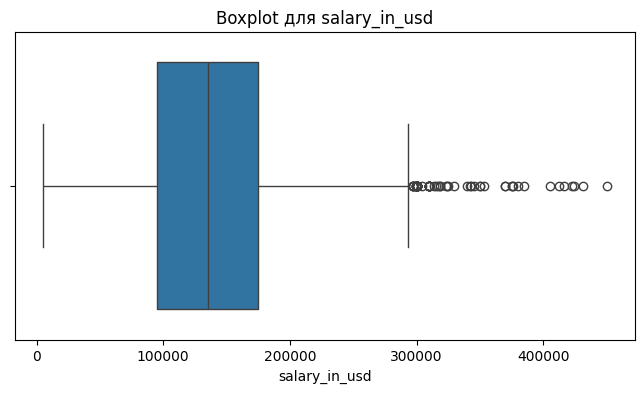

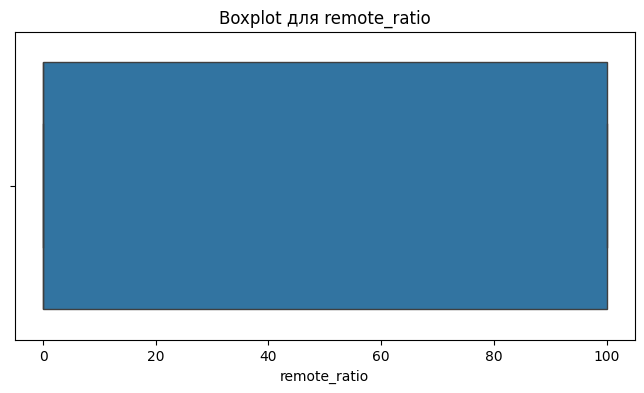

In [ ]:
# потроим боксплоты
for col in df.select_dtypes(include='int').columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot для {col}')
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()

изменим remote_ratio так как в нем всего 3 значенния

In [ ]:
df['remote_ratio'] = df['remote_ratio'].astype('object')

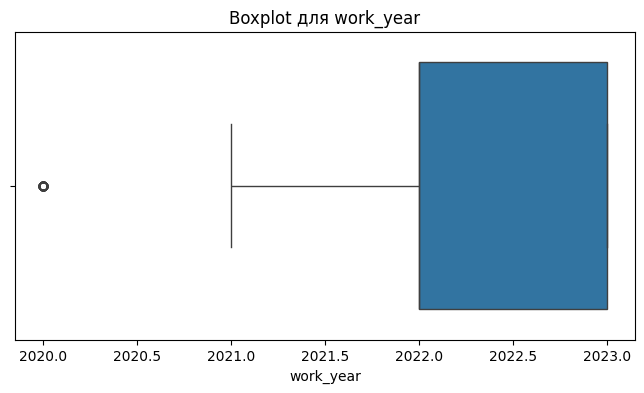

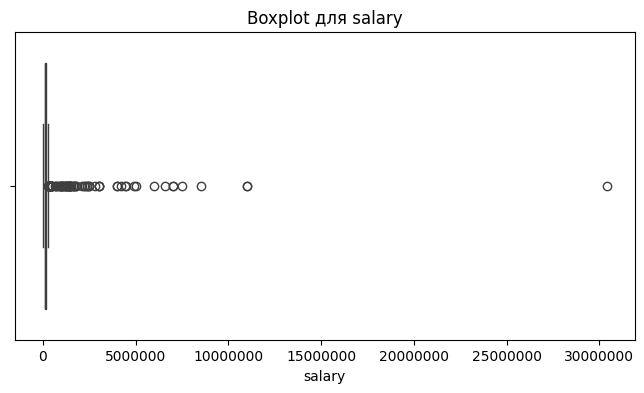

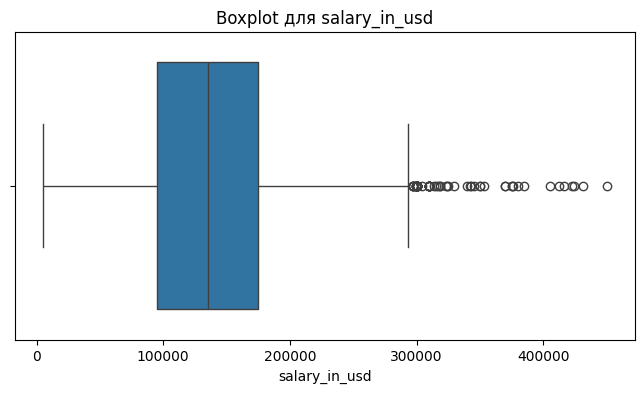

In [ ]:
# потроим боксплоты
for col in df.select_dtypes(include='int').columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot для {col}')
    plt.ticklabel_format(style='plain', axis='x')
    plt.show()

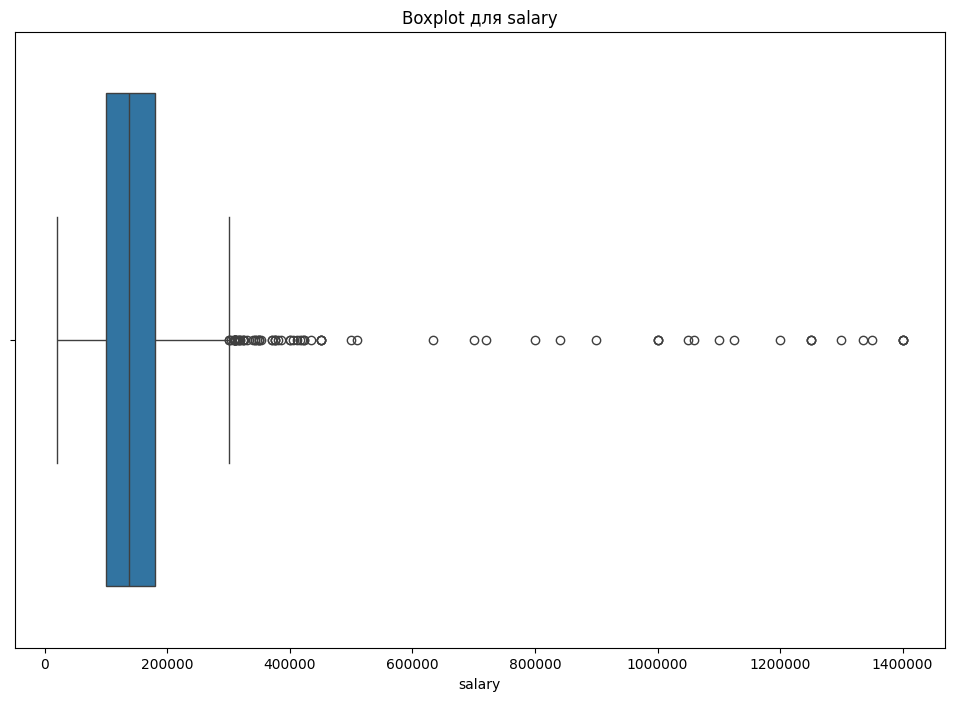

In [ ]:
# boxplot по salary
Q1 = df['salary'].quantile(0.01)
Q3 = df['salary'].quantile(0.99)
df_filtered = df[(df['salary'] >= Q1) & (df['salary'] <= Q3)]

plt.figure(figsize=(12, 8))
sns.boxplot(x=df_filtered['salary'])
plt.title('Boxplot для salary')
plt.ticklabel_format(style='plain', axis='x')
plt.show()

In [ ]:
# выброс по salary
df[df['salary']==30_400_000]

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
3669,2021,MI,FT,Data Scientist,30400000,CLP,40038,CL,100,CL,L


Зраплата в норме,если смотреть в долларах

В заключении следует отметить:
1. Нет пропусков.
2. Заменили remotr_ratio на  object
3. Описательная статистика в норме


## **Задание 3 (0.3 балла)**

Вернитесь к описанию признаков.
- Проверьте, все ли признаки соответствуют постановке задачи? Если есть лишние признаки, удалите их и обоснуйте удаление, если нет, сделайте вывод о релевантности (достаточно в одну-две строки)
- Зафиксируйте, в каких признаках много категорий.

 Можно удалить признак salary и оставить только salary_in_usd, чтобы для каждого объекта зарплата была в долларах, возможно salary может сильно коррелировать с таргетом

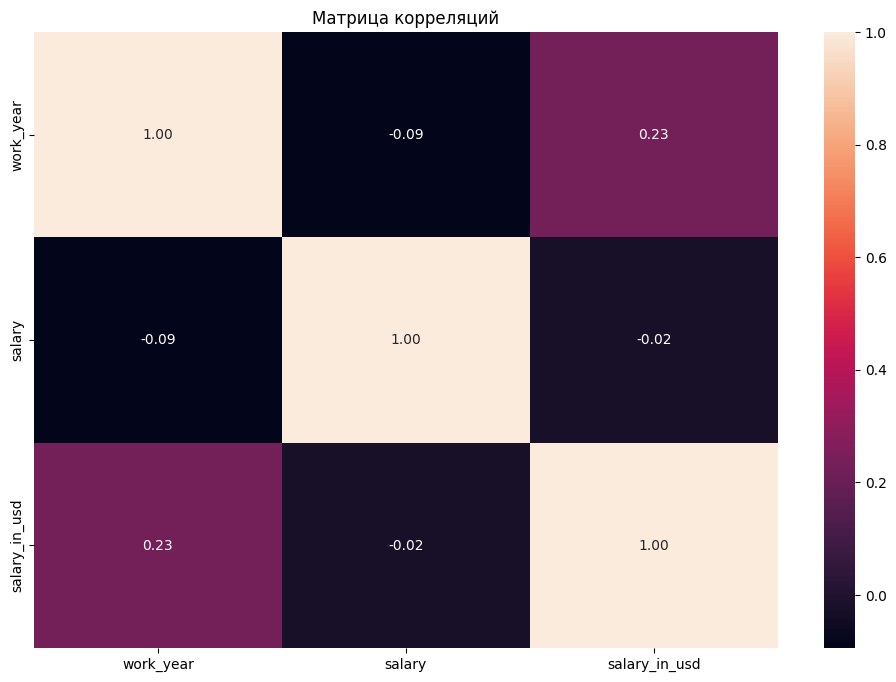

In [ ]:
# проверяем корреляцию
df_num = df.select_dtypes(include=['int64'])
corr_matrix = df_num.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f')
plt.title('Матрица корреляций')
plt.show()

Мои догадки не оказались успешными, но в таком случае пока что оставим salary

In [ ]:
# Уникальные категории
unique_counts = df.nunique()
unique_counts.sort_values(ascending=False)

,0
salary_in_usd,1035
salary,815
job_title,93
employee_residence,78
company_location,72
salary_currency,20
work_year,4
experience_level,4
employment_type,4
remote_ratio,3


salary_in_usd признак с наибольшими категориями

## **Задание 4 (0.2 балла)**

Разделите выборку на train, test (80%, 20%).

In [ ]:
X = df.drop(columns = 'salary_in_usd', axis =1)
y = df['salary_in_usd']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

## **Задание 5 (0.3 балла)**

Будем проверять два сценария. Первый — построение модели только на непрерывных признаках, а второй — построение с категориальными. В этом задании подготовьте всё, чтобы проверить валидность обоих сценариев. А именно:

- Выделите данные для тренировки и теста для непрерывных признаков
- Выделите данные для тренировки и теста для непрерывных + категориальных признаков, пока ничего не кодируйте.

In [ ]:
X_train_cont = X_train[['work_year', 'salary']]
X_test_cont = X_test[['work_year', 'salary']]

## **Задание 6 (0.2 балла)**

- Обучите модель линейной регресии на числовых признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
def LinearRegressionModel(Xtrain, Xtest, ytrain):
  model = LinearRegression()
  model.fit(Xtrain, ytrain)

  y_pred = model.predict(Xtest)
  return model, y_pred

In [ ]:
def standardize_data(Xtrain, Xtest):
  scaler = StandardScaler()

  Xtrain_scaled = scaler.fit_transform(Xtrain)
  Xtest_scaled = scaler.transform(Xtest)

  Xtrain = pd.DataFrame(Xtrain_scaled, columns=Xtrain.columns)
  Xtest = pd.DataFrame(Xtest_scaled, columns=Xtest.columns)

  return Xtrain, Xtest

In [ ]:
# стандартизируем данные
X_train_cont, X_test_cont = standardize_data(X_train_cont, X_test_cont)

In [ ]:
model_lr, y_pred_lr = LinearRegressionModel(X_train_cont, X_test_cont, y_train)

In [ ]:
rmse_score_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f'RMSE: {rmse_score_lr}')

mape_score_lr = np.mean(np.abs((y_test - y_pred_lr) / y_test)) * 100
print(f'MAPE: {mape_score_lr}')

RMSE: 61362.98323942841
MAPE: 70.62703129221491


 Мы ошибаемся примерно на 61362 долларов и 7000 процентов точности, что указывает на ужасную модель

## **Задание 8 (0.2 балла)**

- Обучите модель бустинга (любую из трех библиотек catboost, xgboost, lightgbm) с гиперпараметрами по умолчанию на непрерывных признаках и оцените её качество через mape и rmse;
- Сделайте вывод о качестве построенной модели;

In [ ]:
from catboost import CatBoostRegressor
from category_encoders import TargetEncoder

In [ ]:
def CatBoostModel(Xtrain, Xtest, ytrain):
  model = CatBoostRegressor(verbose=False, random_state=42)
  model.fit(Xtrain, ytrain)

  y_pred = model.predict(Xtest)
  return model, y_pred

In [ ]:
model_cbr, y_pred_cbr = CatBoostModel(X_train_cont, X_test_cont, y_train)

In [ ]:
rmse_cbr = np.sqrt(mean_squared_error(y_test, y_pred_cbr))
mape_cbr = mean_absolute_percentage_error(y_test, y_pred_cbr)

print(f"RMSE: {rmse_cbr}")
print(f"MAPE: {mape_cbr}")

RMSE: 18700.984276758547
MAPE: 0.222365950525147


Результат уже лучше, чем был,причем намного лучше,  но все равно можно лучше.

## **Задание 9 (0.8 балла)**

Теперь подключим категориальные признаки. Но попроубем разные стратегии предобработки.

**1:**
- Предобработайте категориальные признаки при помощи OHE
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**2:**
- Предобработайте категориальные признаки при помощи LabelEncoding
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

**3:**
- Предобработайте категориальные признаки при помощи MeanTargetEnc
- Постройте модель бустинга и линейную регрессию
- Оцените качество обеих моделей

Сделайте выводы по построениям 1-3. Выберите лучшую модель и дальше поработайте с ней.

# №1

In [ ]:
categor = list(X_train.select_dtypes(include='object').columns)

In [ ]:
# OHE
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')

ohe.fit(X_train[categor])

X_train_met_ohe = pd.DataFrame(ohe.transform(X_train[categor]).toarray(),
                           columns=ohe.get_feature_names_out(input_features=categor))

X_test_met_ohe = pd.DataFrame(ohe.transform(X_test[categor]).toarray(),
                         columns=ohe.get_feature_names_out(input_features=categor))

# удаляем исходные категориальные признаки
X_train_not_cat = X_train.drop(columns=categor).reset_index(drop=True)
X_test_not_cat = X_test.drop(columns=categor).reset_index(drop=True)

X_train_ohe = pd.concat([X_train_not_cat, X_train_met_ohe], axis=1)
X_test_ohe = pd.concat([X_test_not_cat, X_test_met_ohe], axis=1)

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [2, 3, 4, 6] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
model_rfr_check = RandomForestRegressor(n_estimators=100, random_state=42)
model_rfr_check.fit(X_train_ohe, y_train)

y_pred_rfr_check = model_rfr_check.predict(X_test_ohe)

In [ ]:
mse_rfr = mean_squared_error(y_test, y_pred_rfr_check)
print(f'MSE random forest: {mse_rfr:.2f}')

MSE random forest: 69105851.07


In [ ]:
feature_importances = model_rfr_check.feature_importances_

importance_df = pd.DataFrame({
    'Признак': X_train_ohe.columns,
    'Важность': feature_importances
})

# топ-10 самых важных признаков
importance_df.sort_values(by='Важность', ascending=False).head(10)

,Признак,Важность
1,salary,0.876727
109,salary_currency_USD,0.048673
102,salary_currency_INR,0.040952
146,employee_residence_IN,0.004171
101,salary_currency_ILS,0.003184
218,company_location_IL,0.002524
183,remote_ratio_50,0.001880
9,job_title_AI Scientist,0.001204
145,employee_residence_IL,0.001114
99,salary_currency_GBP,0.001081


Модель подстраивается под salary, удалим данный столбец

In [ ]:
X_train.drop(columns='salary', axis=1, inplace=True)
X_test.drop(columns='salary', axis=1, inplace=True)

X_train_ohe.drop(columns='salary', axis=1, inplace=True)
X_test_ohe.drop(columns='salary', axis=1, inplace=True)

In [ ]:
# стандартизация
X_train_ohe, X_test_ohe = standardize_data(X_train_ohe, X_test_ohe)

In [ ]:
# LinReg
model_lr_ohe, y_pred_lr_ohe = LinearRegressionModel(X_train_ohe, X_test_ohe, y_train)

In [ ]:
rmse_score_ohe = np.sqrt(mean_squared_error(y_test, y_pred_lr_ohe))
print(f'RMSE линейной регресии на числовых и кат. признаках: {rmse_score_ohe:.2f}')

mape_score_ohe = mean_absolute_percentage_error(y_test, y_pred_lr_ohe)
print(f'MAPE линейной регрессии на числовых и кат. признаках: {mape_score_ohe}')

RMSE линейной регресии на числовых и кат. признаках: 49340.58
MAPE линейной регрессии на числовых и кат. признаках: 0.4004810637862937


In [ ]:
# CatBoost
model_cbr_ohe, y_pred_cbr_ohe = CatBoostModel(X_train_ohe, X_test_ohe, y_train)

In [ ]:
rmse_cbr_ohe = np.sqrt(mean_squared_error(y_test, y_pred_cbr_ohe))
print(f"RMSE CatBoost: {rmse_cbr_ohe:.2f}")

mape_cbr_ohe = mean_absolute_percentage_error(y_test, y_pred_cbr_ohe)
print(f"MAPE CatBoost: {mape_cbr_ohe:}")


RMSE CatBoost: 48096.74
MAPE CatBoost: 0.3669597592315807


По показателям обе модельки показывают слебенький результат, но явно лучше, чем было с саомго начала вместе с колнкой salary

# №2

In [ ]:
X_train_le = X_train.copy()
X_test_le = X_test.copy()

# создаем и обучаем LabelEncoder для каждой категориальной колонки
label_encoders = {}
for col in categor:
  le = LabelEncoder()
  le.fit(X_train[col])
  label_encoders[col] = le

# применяем LabelEncoder к тренировочным данным
for col in categor:
  X_train_le[col + '_encoded'] = label_encoders[col].transform(X_train_le[col])

# заменим неизвестныекатегории из теста на "-1"

for col in categor:
    X_test_le[col + '_encoded'] = X_test_le[col].apply(
        lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)

# удаляем исходные категориальные столбцы
X_train_le = X_train_le.drop(columns=categor).reset_index(drop=True)
X_test_le = X_test_le.drop(columns=categor).reset_index(drop=True)

In [ ]:
# стандартизация
X_train_le, X_test_le = standardize_data(X_train_le, X_test_le)

In [ ]:
# LinReg
model_lr_le, y_pred_lr_le = LinearRegressionModel(X_train_le, X_test_le, y_train)

In [ ]:
rmse_score_le = np.sqrt(mean_squared_error(y_test, y_pred_lr_le))
print(f'RMSE LinReg: {rmse_score_le}')

mape_score_le = mean_absolute_percentage_error(y_test, y_pred_lr_le)
print(f'MAPE LinReg: {mape_score_le}')

RMSE LinReg: 52141.308162343696
MAPE LinReg: 0.4957847079587375


In [ ]:
# CatBoost
model_cbr_le, y_pred_cbr_le = CatBoostModel(X_train_le, X_test_le, y_train)

In [ ]:
rmse_cbr_le = np.sqrt(mean_squared_error(y_test, y_pred_cbr_le))
print(f"RMSE CatBoost: {rmse_cbr_le}")

mape_cbr_le = mean_absolute_percentage_error(y_test, y_pred_cbr_le)
print(f"MAPE CatBoost: {mape_cbr_le}")

RMSE CatBoost: 48304.9020507048
MAPE CatBoost: 0.4026621131511094


с применением LabelEncoder линейная регрессия показала результат хуже, чем с OHE, CatBoost почти без изменений и по метрике лучше.

# №3

In [ ]:
# MeanTargetEnc
encoder = TargetEncoder(cols=categor, smoothing=1.0)

X_train_enc = encoder.fit_transform(X_train[categor], y_train)
X_test_enc = encoder.transform(X_test[categor])

X_train_enc = pd.DataFrame(X_train_enc, columns=categor)

# возвращаем числовой столбец с годом
X_train_enc['work_year'] = X_train['work_year']
X_test_enc['work_year'] = X_test['work_year']

In [ ]:
# стандартизация
X_train_enc, X_test_enc = standardize_data(X_train_enc, X_test_enc)

In [ ]:
# LinReg
model_lr_enc, y_pred_lr_enc = LinearRegressionModel(X_train_enc, X_test_enc, y_train)

In [ ]:
rmse_score_enc = np.sqrt(mean_squared_error(y_test, y_pred_lr_enc))
print(f'RMSE LinReg: {rmse_score_enc}')

mape_score_enc = mean_absolute_percentage_error(y_test, y_pred_lr_enc)
print(f'MAPE LinReg: {mape_score_enc}')

RMSE LinReg: 49313.37409935859
MAPE lInReg: 0.4221279555909058


In [ ]:
# CatBoost
model_cbr_enc, y_pred_cbr_enc = CatBoostModel(X_train_enc, X_test_enc, y_train)

In [ ]:
rmse_cbr_enc = np.sqrt(mean_squared_error(y_test, y_pred_cbr_enc))
print(f"RMSE CatBoost: {rmse_cbr_enc}")

mape_cbr_enc = mean_absolute_percentage_error(y_test, y_pred_cbr_enc)
print(f"MAPE CatBoost: {mape_cbr_enc}")

RMSE CatBoost: 47569.50619829399
MAPE CatBoost: 0.38125669166735604


 TargetEncoder модель CatBoost показала результат лучше LinReg на 2к и 4 процента

лучший результат получился с применением TargetEncoder и CatBoost. RMSE = 47569 MAPE = 0.38

## **Задание 10 (0.5 балла)**

Покажите, где ошибается ваша модель. Выведите топ 20 примеров с наибольшей ошибкой. Проанализируйте их. Какие выводы можно сделать? Что стоит изменить в данных чтобы улучшить качество модели?

In [ ]:
errors = abs(y_pred_cbr_enc - y_test)
top_20_errors = X_test.copy()
top_20_errors['errors'] = errors
top_20_errors.sort_values(by='errors', ascending=False).head(20)

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,errors
1288,2023,SE,FT,Data Analyst,USD,US,0,US,M,253916.084728
1105,2023,SE,FT,Data Scientist,USD,US,0,US,M,200602.338330
2589,2022,SE,FT,Product Data Scientist,USD,IN,100,SG,L,185862.615367
2359,2022,SE,FT,Data Science Tech Lead,USD,US,50,US,L,157724.608920
1116,2023,SE,FT,Machine Learning Engineer,USD,US,0,US,M,150102.918622
3713,2020,SE,FT,Data Scientist,USD,US,50,US,L,148518.079810
1593,2023,SE,FT,Data Engineer,USD,US,0,US,M,141509.536648
33,2023,SE,FT,Computer Vision Engineer,USD,US,0,US,M,139779.888604
3609,2020,SE,FT,Machine Learning Scientist,USD,JP,0,JP,S,136415.658596
746,2023,EX,FT,Data Engineer,USD,US,100,US,M,131015.582930


Больше всего ошибок наблюдается на позиции SE, по этой же позиции наблюдаются выбросы, может заменить медианой?

## **Задание 11 (0.5 балла)**

Придумайте признаки для улучшения качества модели на основе предыдущего пункта. Как вам кажется какими признаками можно улучшить качетсво модели? Реализуйте признаки и проверьте улучшилось ли качество модели.

**Примечание:**
Полный балл за задание ставится даже при отсутствии улучшения качества модели, важно попробовать проверить свои гипотезы и сделать выводы.

In [ ]:
# выбросы
Q1 = df['salary_in_usd'].quantile(0.25)
Q3 = df['salary_in_usd'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['median_salary'] = df.groupby(['job_title', 'experience_level', 'employee_residence',
                                  'company_location'])['salary_in_usd'].transform('median')

# заменим выбросы на медианные значения
df_new = df.copy()
df_new['salary_in_usd'] = np.where(
    (df_new['salary_in_usd'] < lower_bound) | (df_new['salary_in_usd'] > upper_bound),
    df_new['median_salary'],
    df_new['salary_in_usd']
)

df_new.drop(columns=['median_salary'], inplace=True)

In [ ]:
df_new['median_salary_by_group'] = df_new.groupby(['job_title', 'experience_level',
                                                   'employee_residence', 'company_location'])['salary_in_usd'].transform('median')

df_new['salary_to_median_ratio'] = df_new['salary_in_usd'] / df_new['median_salary_by_group']

# дропнем median_salary_by_group и salary
df_new.drop(columns=['median_salary_by_group', 'salary'], inplace=True)

In [ ]:
# обучим модель
X_new = df_new.drop(columns='salary_in_usd', axis=1)
y_new = df_new['salary_in_usd']

In [ ]:
# разбивка на train and test
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, random_state = 42)

In [ ]:
X_train_new.head()

,work_year,experience_level,employment_type,job_title,salary_currency,employee_residence,remote_ratio,company_location,company_size,salary_to_median_ratio
2238,2022,SE,FT,Data Engineer,EUR,ES,0,ES,M,0.666667
485,2023,MI,FT,Research Scientist,USD,US,100,US,M,1.008973
2177,2022,SE,FT,Data Analyst,USD,US,0,US,M,0.861790
3305,2022,SE,FT,Data Engineer,USD,US,100,US,M,1.044000
1769,2023,SE,FT,Data Engineer,USD,US,100,US,M,1.166667


In [ ]:
# TargetEncoder
encoder_new = TargetEncoder(cols=categor, smoothing=1.0)

X_train_new_enc = encoder_new.fit_transform(X_train_new[categor], y_train_new)
X_test_new_enc = encoder_new.transform(X_test_new[categor])

X_train_new_enc = pd.DataFrame(X_train_new_enc, columns=categor)

X_train_new_enc['work_year'] = X_train_new['work_year']
X_train_new_enc['salary_to_median_ratio'] = X_train_new['salary_to_median_ratio']

X_test_new_enc['work_year'] = X_test_new['work_year']
X_test_new_enc['salary_to_median_ratio'] = X_test_new['salary_to_median_ratio']

In [ ]:
# CatBoost
model_cbr_new_enc, y_pred_cbr_new_enc = CatBoostModel(X_train_new_enc, X_test_new_enc, y_train_new)

In [ ]:
rmse_cbr_new_enc = np.sqrt(mean_squared_error(y_test_new, y_pred_cbr_new_enc))
print(f"RMSE CatBoost: {rmse_cbr_new_enc}")

mape_cbr_new_enc = mean_absolute_percentage_error(y_test_new, y_pred_cbr_new_enc)
print(f"MAPE CatBoost: {mape_cbr_new_enc}")

RMSE CatBoost: 19507.778159767502
MAPE CatBoost: 0.135277564013048


С добавлением новых признаков дало улучшить значения RMSE = 19507 MAPE = 0.13

## **Задание 12 (1 балл)**

Поупражняемся с разными бустингами!

- Используйте catboost.
- Обучите модель — на полном наборе данных с категориальными признаками.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


**Примечание:**
Замерять скорость = смотреть, как долго исполняется код.

In [ ]:
# CatBoost без кодировки
model_cbr_lite = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100
)

start_time = time()
model_cbr_lite.fit(X_train_new, y_train_new, cat_features=categor)
training_time = time() - start_time

print(f"Время обучения: {training_time:.2f} секунд")

0:	learn: 54792.2959660	total: 10.6ms	remaining: 10.6s
100:	learn: 18070.9651027	total: 1.91s	remaining: 17s
200:	learn: 15371.4818682	total: 3.99s	remaining: 15.9s
300:	learn: 13579.9808793	total: 5.77s	remaining: 13.4s
400:	learn: 12404.5009545	total: 6.92s	remaining: 10.3s
500:	learn: 11427.2541852	total: 7.64s	remaining: 7.61s
600:	learn: 10683.8437783	total: 8.37s	remaining: 5.56s
700:	learn: 10022.2838812	total: 9.13s	remaining: 3.9s
800:	learn: 9441.4459533	total: 9.85s	remaining: 2.45s
900:	learn: 8954.2954509	total: 10.6s	remaining: 1.16s
999:	learn: 8528.9539288	total: 11.3s	remaining: 0us
Время обучения: 11.55 секунд


In [ ]:
y_pred_cbr_lite = model_cbr_lite.predict(X_test_new)

In [ ]:
rmse_cbr_lite = np.sqrt(mean_squared_error(y_test_new, y_pred_cbr_lite))
print(f"RMSE: {rmse_cbr_lite}")

mape_cbr_lite = mean_absolute_percentage_error(y_test_new, y_pred_cbr_lite)
print(f"MAPE: {mape_cbr_lite:}")

RMSE: 20233.808701503276
MAPE: 0.1600615082880055


In [ ]:
# подбор гиперпараметров
model_cbr_search = CatBoostRegressor(cat_features=categor, verbose=0)

param_dist = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'iterations': [500, 1000, 1500]}

random_search = RandomizedSearchCV(
    estimator=model_cbr_search,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42)

start_time = time()
random_search.fit(X_train_new, y_train_new)
end_time = time()

print("Топ гиперпараметры:", random_search.best_params_)
print(f"Время подбора: {end_time - start_time:.2f} секунд")

Fitting 3 folds for each of 18 candidates, totalling 54 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 18 is smaller than n_iter=20. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Топ гиперпараметры: {'learning_rate': 0.1, 'iterations': 1500, 'depth': 6}
Время подбора: 650.73 секунд


Топ гиперпараметры: {'learning_rate': 0.1, 'iterations': 1500, 'depth': 6}
Время подбора: 650.73 секунд

In [ ]:
# обучаем CatBoost на подобранных параметрах
best_model_cbr = CatBoostRegressor(
    iterations=random_search.best_params_['iterations'],
    learning_rate=random_search.best_params_['learning_rate'],
    depth=random_search.best_params_['depth'],
    loss_function='RMSE',
    verbose=100)

start_time = time()
best_model_cbr.fit(X_train_new, y_train_new, cat_features=categor)
best_training_time = time() - start_time

print(f"Время обучения с топ параметрами: {best_training_time:.2f} секунд")

0:	learn: 54792.2959660	total: 8.33ms	remaining: 12.5s
100:	learn: 18070.9651027	total: 732ms	remaining: 10.1s
200:	learn: 15371.4818682	total: 1.45s	remaining: 9.38s
300:	learn: 13579.9808793	total: 2.21s	remaining: 8.79s
400:	learn: 12404.5009545	total: 3.74s	remaining: 10.2s
500:	learn: 11427.2541852	total: 4.96s	remaining: 9.89s
600:	learn: 10683.8437783	total: 5.68s	remaining: 8.5s
700:	learn: 10022.2838812	total: 6.42s	remaining: 7.32s
800:	learn: 9441.4459533	total: 8.03s	remaining: 7.01s
900:	learn: 8954.2954509	total: 9.38s	remaining: 6.23s
1000:	learn: 8524.9916120	total: 10.1s	remaining: 5.05s
1100:	learn: 8085.9681999	total: 10.9s	remaining: 3.94s
1200:	learn: 7680.3218470	total: 11.6s	remaining: 2.9s
1300:	learn: 7364.3727148	total: 12.4s	remaining: 1.89s
1400:	learn: 7000.6520078	total: 13.1s	remaining: 928ms
1499:	learn: 6751.1559256	total: 13.9s	remaining: 0us
Время обучения с топ параметрами: 14.12 секунд


In [ ]:
joblib.dump(best_model_cbr, 'catboost_best_model.pkl')

['catboost_best_model.pkl']

In [ ]:
best_model_cbr = joblib.load('/content/catboost_best_model.pkl')

In [ ]:
start_time = time()
y_pred_best_cbr = best_model_cbr.predict(X_test_new)
prediction_time = time() - start_time
mape_best_cbr = mean_absolute_percentage_error(y_test_new, y_pred_best_cbr)
rmse_best_cbr = np.sqrt(mean_squared_error(y_test_new, y_pred_best_cbr))

print(f"MAPE: {mape_best_cbr}")
print(f"RMSE: {rmse_best_cbr}")
print(f"Время предсказания: {prediction_time} секунд")

MAPE: 0.159586256359874
RMSE: 20039.416185301132
Время предсказания: 0.01876354217529297 секунд


Побор гиперпараметров незначительно улучшил метрику. CatBoost на данных с кодировкой показал результат лучше, чем без неё и подбором гиперпараметров.

## **Задание 13 (1 балл)**

- Используйте xgboost.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.



In [ ]:
# XGboost
xgb_model_lite = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42)

start_time = time()
xgb_model_lite.fit(X_train_new_enc, y_train_new)
training_time_default = time() - start_time
print(f"Время обучения: {training_time_default:.2f} секунд")

Время обучения: 0.15 секунд


In [ ]:
start_time = time()
y_pred_xgb_lite = xgb_model_lite.predict(X_test_new_enc)
prediction_time_default = time() - start_time
rmse_default = np.sqrt(mean_squared_error(y_test_new, y_pred_xgb_lite))
mape_default = mean_absolute_percentage_error(y_test_new, y_pred_xgb_lite)

print(f"Время предсказания: {prediction_time_default:.2f} секунд")
print(f"RMSE: {rmse_default}")
print(f"MAPE: {mape_default}")

Время предсказания: 0.01 секунд
RMSE: 19772.379363053766
MAPE: 0.14767885396392444


In [ ]:
# подбор гиперпараметров
param_dist = {
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 3, 5]}

random_search = RandomizedSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42)

start_time = time()
random_search.fit(X_train_new_enc, y_train_new)
search_time = time() - start_time
print(f"Время подбора гиперпараметров: {search_time:.2f} секунд")

best_params = random_search.best_params_
print("Лучшие гиперпараметры:", best_params)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Время подбора гиперпараметров: 14.70 секунд
Лучшие гиперпараметры: {'subsample': 0.8, 'n_estimators': 300, 'min_child_weight': 3, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.6}


In [ ]:
joblib.dump(xgb_model_lite, 'xgboost_best_model.pkl')

['xgboost_best_model.pkl']

In [ ]:
best_model_xgb = joblib.load('/content/xgboost_best_model.pkl')

In [ ]:
# Обучаем XGboost c лучшими параметрами
best_model_xgb = xgb.XGBRegressor(**best_params, objective='reg:squarederror', eval_metric='rmse', random_state=42)

start_time = time()
best_model_xgb.fit(X_train_new_enc, y_train_new)
training_time_best = time() - start_time
print(f"Время обучения с топ гиперпараметрами:  {training_time_best:.2f} секунд")

Время обучения с топ гиперпараметрами:  0.16 секунд


In [ ]:
start_time = time()
y_pred_best_xgb = best_model_xgb.predict(X_test_new_enc)
prediction_time_best = time() - start_time
print(f"Время предсказания с топ гиперпараметрами: {prediction_time_best:.2f} секунд")

rmse_best_xgb = np.sqrt(mean_squared_error(y_test_new, y_pred_best_xgb))
print(f"RMSE с топ гиперпараметрами: {rmse_best_xgb}")

mape_best_xgb = mean_absolute_percentage_error(y_test_new, y_pred_best_xgb)
print(f"MAPE с топ гиперпараметрами: {mape_best_xgb}")

Время предсказания с топ гиперпараметрами: 0.04 секунд
RMSE с топ гиперпараметрами: 18872.71225999568
MAPE с топ гиперпараметрами: 0.14633525112904391


На данный момент это топ показатели

## **Задание 14 (1 балл)**

- Используйте lgbm.
- Обучите модель — на полном наборе данных с категориальными признаками. Стратегию кодирования оставьте ту, что показала себя лучшей в пункте 9.
- Подберите оптимальные гиперпараметры.
- Оцените качество итоговой модели, скорость обучения и скорость предсказания.


In [ ]:
# LightGBM
lgbm_model_lite = lgb.LGBMRegressor(objective='regression', random_state=42)

start_time = time()
lgbm_model_lite.fit(X_train_new_enc, y_train_new)
training_time_default = time() - start_time
print(f"Время обучения: {training_time_default:.2f} секунд")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 10
[LightGBM] [Info] Start training from score 135768.959554
Время обучения: 0.16 секунд


In [ ]:
start_time = time()
y_pred_lgbm_lite = lgbm_model_lite.predict(X_test_new_enc)
prediction_time_default = time() - start_time
print(f"Время предсказания: {prediction_time_default:.2f} секунд")

rmse_lgbm_lite = np.sqrt(mean_squared_error(y_test_new, y_pred_lgbm_lite))
print(f"RMSE без подбора гиперпараметров: {rmse_lgbm_lite}")

mape_lgbm_lite = mean_absolute_percentage_error(y_test_new, y_pred_lgbm_lite)
print(f"MAPE без подбора гиперпараметров: {mape_lgbm_lite}")

Время предсказания: 0.01 секунд
RMSE без подбора гиперпараметров: 20932.302515651605
MAPE без подбора гиперпараметров: 0.14530323337100212


In [ ]:
# подбор гиперпараметров
param_dist = {
    'num_leaves': [31, 50, 100, 200],
    'max_depth': [-1, 3, 5, 7, 10],  #
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300, 400],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [10, 20, 30],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]}

random_search = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(objective='regression', random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42)

start_time = time()
random_search.fit(X_train_new_enc, y_train_new)
search_time = time() - start_time
print(f"Время подбора гиперпараметров: {search_time:.2f} секунд")

best_params = random_search.best_params_
print("Топ гиперпараметры:", best_params)

Выходные данные были обрезаны до нескольких последних строк (5000).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further 

In [ ]:
joblib.dump(lgbm_model_lite, 'lgbm_best_model.pkl')

['lgbm_best_model.pkl']

In [ ]:
best_lgbm = joblib.load('/content/lgbm_best_model.pkl')

In [ ]:
best_lgbm = lgb.LGBMRegressor(**best_params, objective='regression', random_state=42)

start_time = time()
best_lgbm.fit(X_train_new_enc, y_train_new)
training_time_best = time() - start_time
print(f"Время обучения (с лучшими гиперпараметрами): {training_time_best:.2f} секунд")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 455
[LightGBM] [Info] Number of data points in the train set: 3004, number of used features: 10
[LightGBM] [Info] Start training from score 135768.959554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [ ]:
start_time = time()
y_pred_best_lgmb = best_lgbm.predict(X_test_new_enc)
prediction_time_best = time() - start_time
print(f"Время предсказания с топ гиперпараметрами: {prediction_time_best} секунд")

rmse_best_lgbm = np.sqrt(mean_squared_error(y_test_new, y_pred_best_lgmb))
print(f"RMSE с топ гиперпараметрами: {rmse_best_lgbm}")
mape_best_lgbm = mean_absolute_percentage_error(y_test_new, y_pred_best_lgmb)
print(f"MAPE с топ гиперпараметрами: {mape_best_lgbm:}")

Время предсказания с топ гиперпараметрами: 0.022003889083862305 секунд
RMSE с топ гиперпараметрами: 20371.171885203497
MAPE с топ гиперпараметрами: 0.15418587073708143


Ненмого улучшили показатели

## **Задание 15 (0.4 балла)**

Сделайте выводы про модели и решение задачи.

- Какая из моделей показала лучший результат по качеству?
- Какая из моделей показала лучший результат по качеству, скорости обучения и скорости предсказания в совокупности?
- Насколько бустинги превзошли линейную модель? Целесообразно ли их использование?

Лучший результат у XGboost RMSE = 18873, MAPE = 0.14  с подбором гиперпараметров на закодированных признаках с помощью TargetEncoder. XGboost показал лучший результат по метрке и по скорости подбора гиперпараметров.

LinReg полностью проиграл, бустинг целесообразно использовать

# **Часть 2: кластеризация типов движений**
**Количество баллов:** 3

В этой части будем работать с набором данных Samsung Human Activity Recognition. Набор данных заранее предобработан и снова доступен вам по [ссылке](https://drive.google.com/file/d/16ISu7lMumt5rbticbOggHMRjwTGBETtO/view?usp=sharing).

### **Постановка задачи**
Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S2. Вид активности человека с телефоном в кармане известен:
- 1 - ходьба,
- 2 - подъем вверх по лестнице,
- 3 - спуск по лестнице,
- 4 - сидение,
- 5 - стояние,
- 6 - лежание


Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [ ]:
plt.style.use(['seaborn-v0_8-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

%matplotlib inline
%config InlineBackend.figure_format="retina"

RANDOM_STATE = 42

In [ ]:
x1 = pd.read_csv('/content/samsung_train.txt', sep='\s+', header=None)
x2 = pd.read_csv('/content/samsung_test.txt', sep='\s+', header=None)

y1 = pd.read_csv('/content/samsung_train_labels.txt', sep='\s+', header=None)
y2 = pd.read_csv('/content/samsung_test_labels.txt', sep='\s+', header=None)

### **Задание 16 (0.1 балл)**
Прочитайте данные из файлов и объедните тестовую и обучающие выборки.

В файлах ```..._labels``` лежат настоящие классы. Их также объедините, но в отдельную переменную (например ```y```). Данный вектор для кластеризации нам не нужен, но мы будем смотреть по нему метрики.

In [ ]:
X = pd.concat([x1, x2], axis=0, ignore_index=True)
y = pd.concat([y1, y2], axis=0, ignore_index=True)

In [ ]:
# убедимся, что y содержит нужные нам классы
np.unique(y)

array([1, 2, 3, 4, 5, 6])

### **Задание 17 (0.2 балла)**

Так как мы будем пользоваться метрическими алгоритмами, отмасштабируйте выборку с помощью ```StandardScaler```.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### **Задание 18 (0.5 балла)**

Данных много и размерность большая. Чтобы ускорить рещение задачи с точки зрения построения модели, мы используем методы **понижения размерности**.

- Понизьте размерность с помощью `PCA`, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии отмасштабированных данных. Вам пригодится [документация](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

**Примечание:**
Для этого сумма значений массива pca.explained_variance_ratio_ должна быть не меньше 0.9.  ```random_state``` используйте из объявленной в самом начале переменной ```RANDOM_STATE``` (42).

In [ ]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

explained_variance_ratio = pca.explained_variance_ratio_.sum()

print(f"Количество оставленных компонент: {pca.n_components_}")
print(f"Объясненная дисперсия: {explained_variance_ratio:.2f}")

Количество оставленных компонент: 65
Объясненная дисперсия: 0.90


### **Задание 19 (0.2 балла)**

Визуализируйте данные в проекции на первые две главные компоненты. Используйте ```cmap="virdis"``` или любой другой, с которым будет красиво!

Можете раскрасить кластеры.

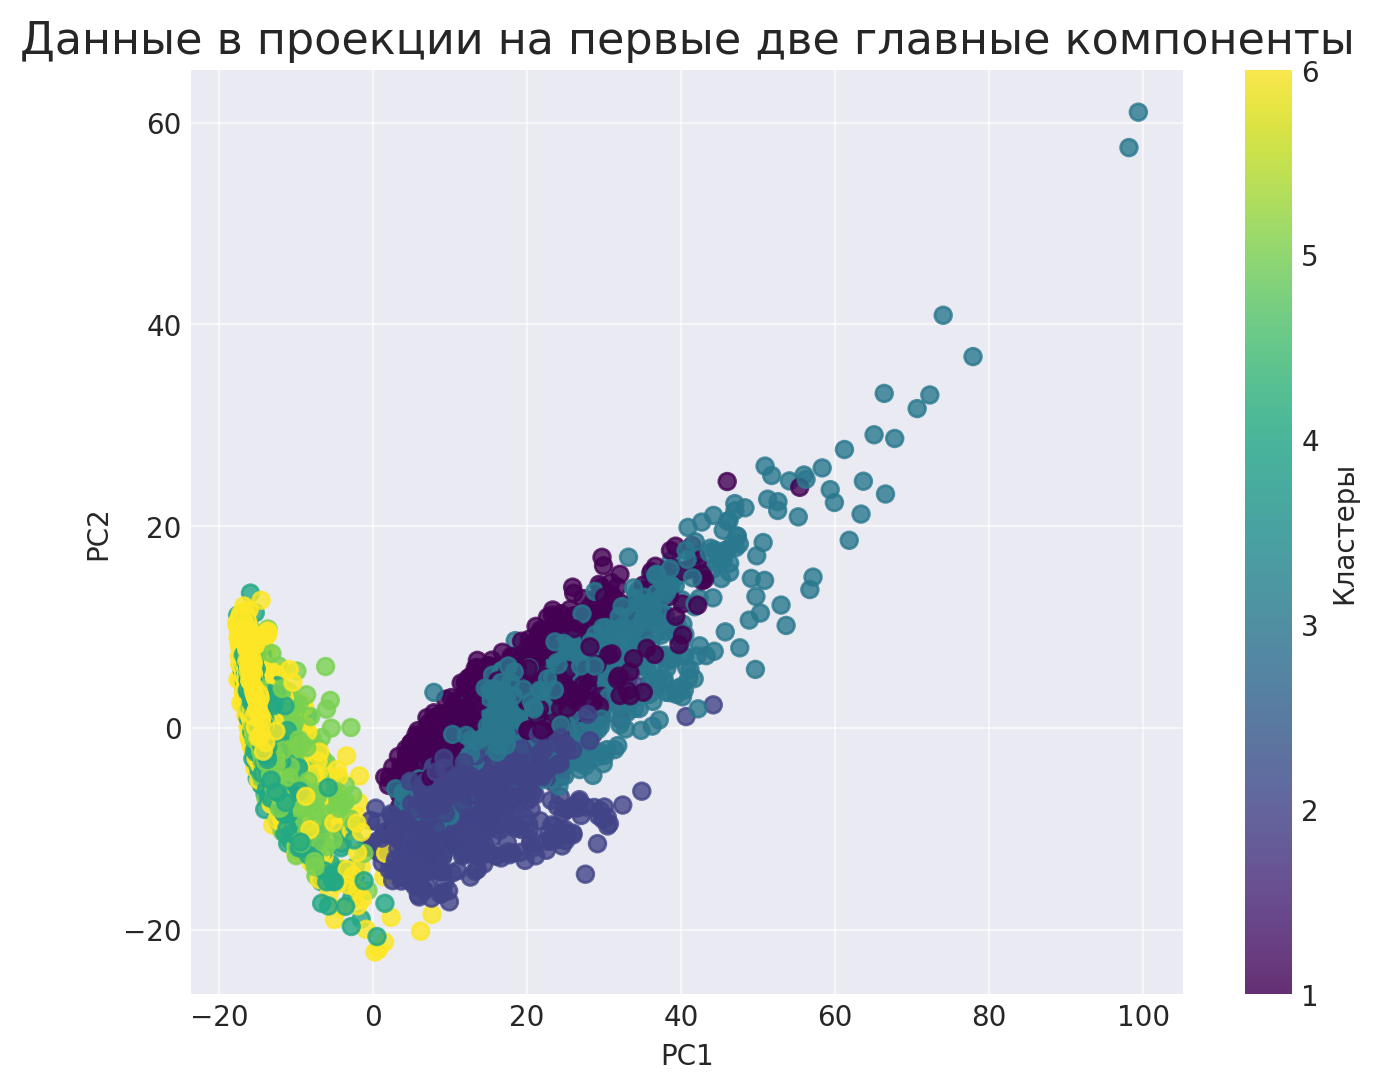

In [ ]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, alpha=0.8, cmap="viridis")
plt.colorbar(scatter, label="Кластеры")

plt.title("Данные в проекции на первые две главные компоненты", fontsize=16)
plt.xlabel("PC1", fontsize=10)
plt.ylabel("PC2", fontsize=10)
plt.grid(True, linestyle='-', alpha=0.6)

plt.show()

### **Задание 19. (0.5 балла)**

Разберёмся с `KMeans`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

- Сделайте кластеризацию данных методом `KMeans`, обучив модель на данных со сниженной за счет `PCA` размерностью. Нужно искать 6 кластеров (изначально у нас 6 классов). Засеките время обучения и время инференса.

**Параметры обучения:**

```n_clusters = 6``` (число уникальных меток целевого класса = 6)

```n_init = 100```

```random_state = RANDOM_STATE``` (для воспроизводимости результата, не забывайте указывать его и дальше!)

In [ ]:
# параметры для KMeans
n_clusters = 6
n_init = 100
random_state = RANDOM_STATE

kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, random_state=random_state)

# время обучения
start_time = time()
kmeans.fit(X_pca)
training_time = time() - start_time

# время предсказания
start_time = time()
y_pred_kmeans = kmeans.predict(X_pca)
predict_time = time() - start_time

print(f'Время обучения: {training_time:.2f} сек.')
print(f'Время предсказания: {predict_time:.2f} сек.')

Время обучения: 11.15 сек.
Время предсказания: 0.00 сек.


### **Задание 20 (0.2 балла)**

- Визуализируйте данные в проекции на первые две главные компоненты.
- Раскрасьте точки в соответствии с полученными метками кластеров.

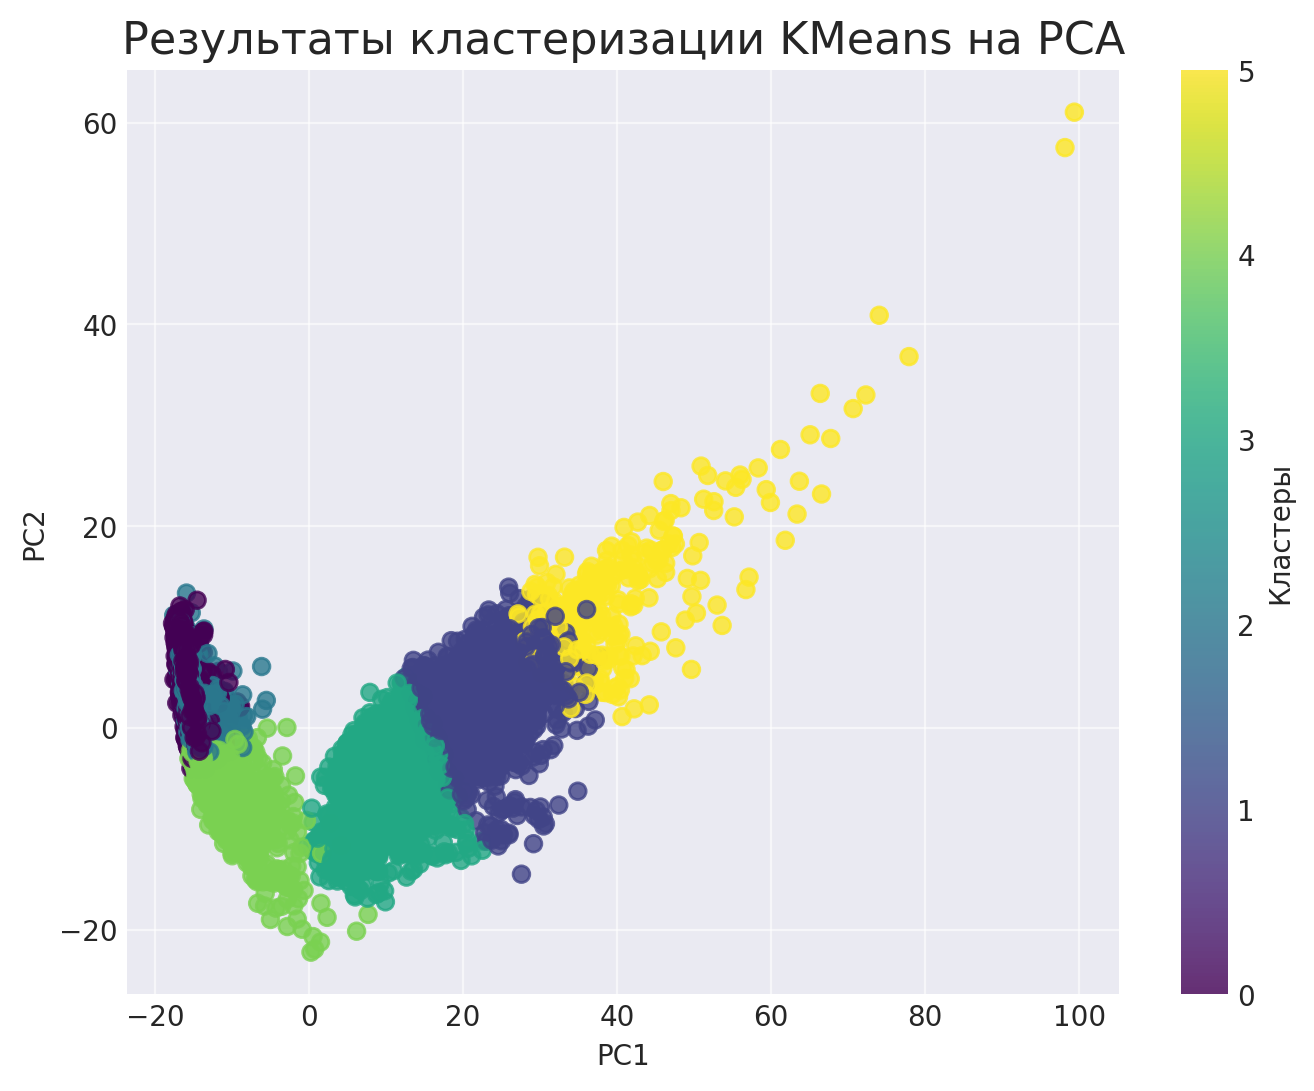

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_kmeans, alpha=0.8, cmap="viridis")
plt.colorbar(scatter, label="Кластеры")
plt.title("Результаты кластеризации KMeans на PCA", fontsize=16)
plt.xlabel("PC1", fontsize=10)
plt.ylabel("PC2", fontsize=10)
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

### **Задание 21 (0.3 балла)**

- Выберите какие-то метрики (минимум две) из известных вам. Объясните свой выбор
- Выведите на экран значения метрик качества, сделайте вывод о них и используйте их далее.

1. Silhouette Score - посотрим как объекты внутри кластеров схожи друг с другом и отличаются от объектов в других кластерах
2. Davies-Bouldin Index - измерим среднее сходство между кластерами

In [ ]:
silhouette_metric = silhouette_score(X_pca, y_pred_kmeans)
davies_bouldin_metric = davies_bouldin_score(X_pca, y_pred_kmeans)

print(f"Silhouette Score: {silhouette_metric}")
print(f"Davies-Bouldin Index: {davies_bouldin_metric}")

Silhouette Score: 0.14149759467581463
Davies-Bouldin Index: 2.051945296086496


1. Silhouette Score = 0.14, а значения разрешеный от -1 до 1, классы пересекаются и иимеют не очень хорошую структурированность.
2.  Davies-Bouldin Index= 2.05 это нам говорит о плохом показателе, кластеры нечестко отделены

### **Задание 22 (0.7 баллов)**

Теперь попробуем сделать кластеризацию с помощью `AgglomerativeClustering`, [doc](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

- Засеките время обучения и время инференса. После кластеризации также:
  - Вновь визуализируйте данные с раскраской по полученным меткам
  - Выведите метрики. Засеките время обучения и время инференса. Сравните с ```KMeans```.

Ответьте на следующие вопросы:
* Стало ли лучше?
* Почему?

In [ ]:
# AgglomerativeClustering
agg_clustering = AgglomerativeClustering(n_clusters=6)

start_trein_predict_agg = time()
y_pred_agg = agg_clustering.fit_predict(X_pca)
time_trein_predict_agg = time() - start_trein_predict_agg

print(f'Время обучения и предсказания: {time_trein_predict_agg:.2f} сек.')

Время обучения и предсказания: 11.77 сек.


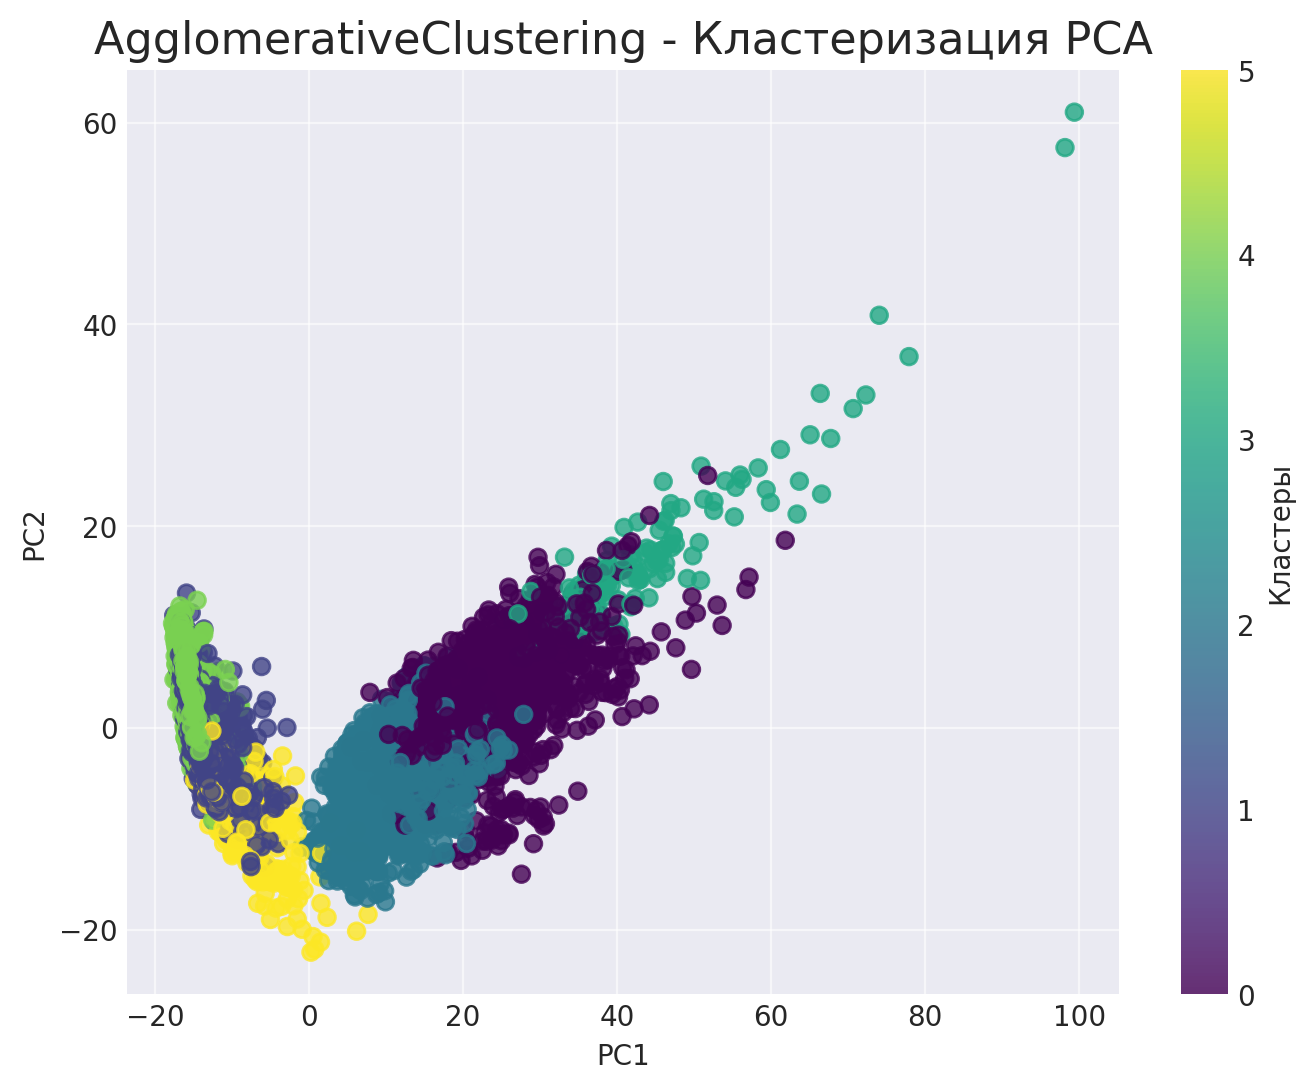

In [ ]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_agg, cmap="viridis", alpha=0.8)
plt.colorbar(scatter, label="Кластеры")
plt.title("AgglomerativeClustering - Кластеризация PCA", fontsize=16)
plt.xlabel("PC1", fontsize=10)
plt.ylabel("PC2", fontsize=10)
plt.grid(True, linestyle='-', alpha=0.6)
plt.show()

In [ ]:
silhouette_agg = silhouette_score(X_pca, y_pred_agg)
davies_bouldin_agg = davies_bouldin_score(X_pca, y_pred_agg)

print(f"Silhouette Score agg: {silhouette_agg:.2f}")
print(f"Davies-Bouldin Index agg: {davies_bouldin_agg:.2f}")

Silhouette Score agg: 0.14
Davies-Bouldin Index agg: 2.04


Можно сказать, что ничего не поменялось, Заметно, что данные не образуют четкой структуры, может из-за этого метрики низкие


### **Задание 23 (0.3 балла)**
Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* Похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* В каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* Качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

1.  Кластера напоминают определенные типы активности человека, видно, что класс 5 находится вышего других.
2.  Классы 1 и 2 смешиваются, это может быть связано с тем, что пользователь выполняет похожие или одни и те же активности.
3. Честно сказать, плохая клсеризация вышла, они накладываются друг на друга

## **Бонус-задание (1 балл)**
![RedPanda](http://imgur.com/6Aa52Lm.png)

Алгоритмы кластеризации могут применяться в самых разных задачах. Например, в анализе изображений есть задача разделения изображения на семантические компоненты, которую можно решать в том числе с помощью алгоритмов кластеризации. В бонусе предлагаем вам попрактиковаться именно в этом на чудесной утке и совах (```duck.jpg``` и ```owls.jpg```)

### **(0.1 балл)**

- Откройте изображения, после чего визуализируйте их с помощью ```plt.imshow()```

In [ ]:
from PIL import Image
# or
#import cv2

### **(0.4 балла)**

Для каждого изображения, используя кластеризацию ```KMeans```, выделите компоненты, охарактеризовав каждый пиксель следующим образом: $$\psi_i = [\lambda x_i, \lambda y_i, r_i, g_i, b_i]$$
 где
- $x_i$ и $y_i$ — координаты пикселя,
- $r_i, g_i, b_i$ — его цвет,
- $\lambda$ — параметр, выражающий важность пространственной связности перед цветовой похожестью.

Примените полученную функцию, взяв следующие $\lambda$: 0.3 и 1.5 для ```duck.jpg``` и ```owls.jpg``` (или другие, но тогда с вас красивые результаты :) )

**Примечание:**
Число кластеров подберите разумным образом на свой вкус (в качестве нулевого приближения можно взять 3)

In [ ]:
def find_components(image, lmbd, n_clusters):
    #your code here

### **(0.4 балла)**

Попробуйте выделить сегменты при помощи [спектральной кластеризации](http://scikit-learn.org/stable/modules/clustering.html#spectral-clustering). Обратите внимание на [пример в sklearn](http://scikit-learn.org/0.16/auto_examples/cluster/plot_lena_segmentation.html).


**Примечание:**

Для ускорения работы алгоритма рекомендуется привести изображение к серому цвету. При необходимости можно сжать изображения в 2 раза.

**Подсказка:**```skimage``` с его ```color``` и ```transform``` в этом помогут :)

Или же воспользуйтесь аналогичными средствами ```PIL``` или ```cv2```

In [ ]:
def spectral_segmentation(image, n_clusters, beta, eps):
    #your code here

### **(0.1 балл)**
Визуализируйте результаты сегментации (аналогично рисунку в начале задания 2) для обоих методов.

**Спасибо! Вы — человек — большой трудяга!**

Успокоительный котобонус :)

Предположу по пальцам, что кот Романа

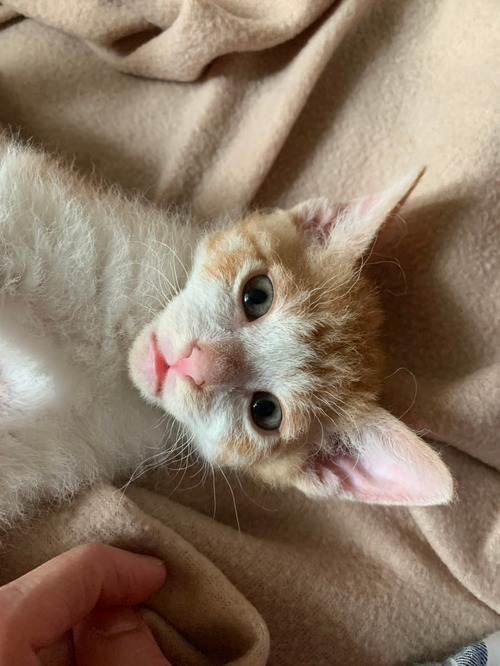